In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import psycopg2
import json

In [3]:
dbconf = None
with open('/Users/atfienberg/g-2/sipmometer/config/dbconnection.json', 'r') as f:
    dbconf = json.load(f)

In [4]:
cnx = psycopg2.connect(user=dbconf['user'], password=dbconf['password'],
                                  host=dbconf['host'],
                                  database=dbconf['dbname'], port=dbconf['port'])
cursor=cnx.cursor()
cursor.execute("select value, time from g2sc_values where channel='calo21temps'")
datalist = []
timelist = []
for (temps, time) in cursor:
    datalist.append(temps)
    timelist.append(time)
data=np.asarray(datalist)
times=np.asarray(timelist)
#mask out temps with failed reads
mdata = np.ma.masked_where(np.logical_or(data<=20, data >=50), data)
cursor.close()
cnx.close()

<IPython.core.display.Javascript object>


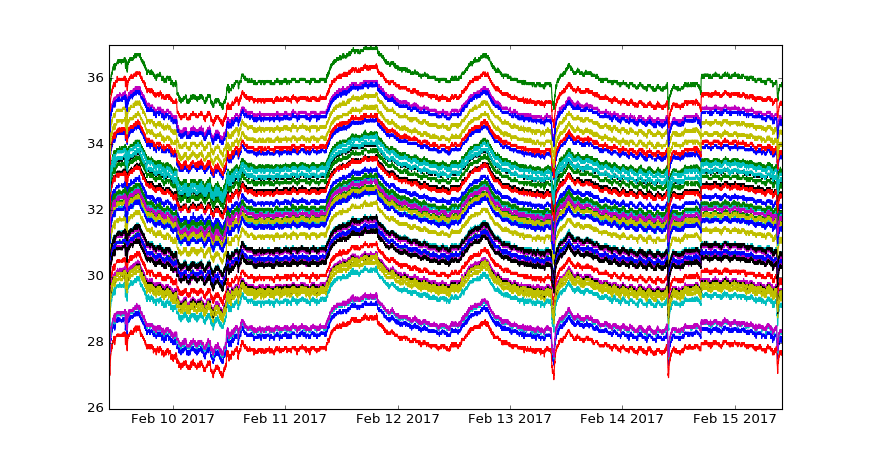

In [5]:
allplots=plt.plot(times, mdata)
lims=plt.ylim(26,37)

<IPython.core.display.Javascript object>


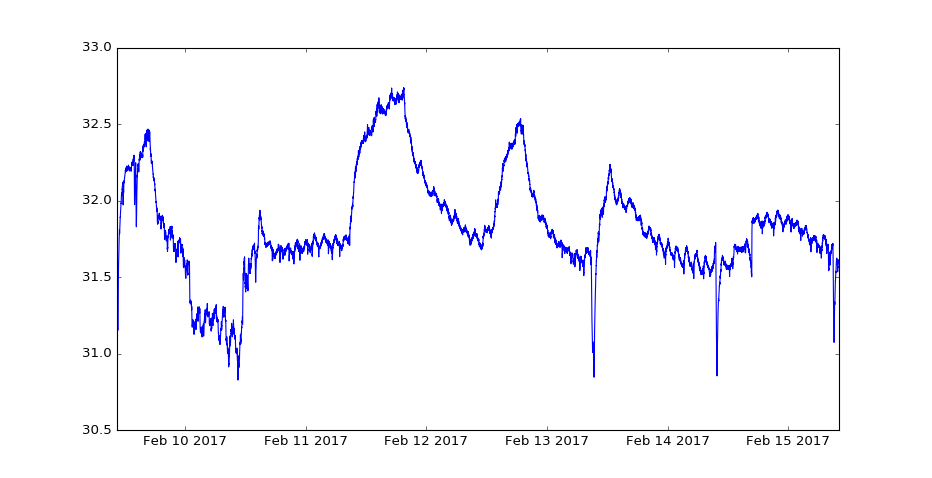

In [6]:
avgplot = plt.plot(timelist, np.mean(mdata, axis=1))

<IPython.core.display.Javascript object>


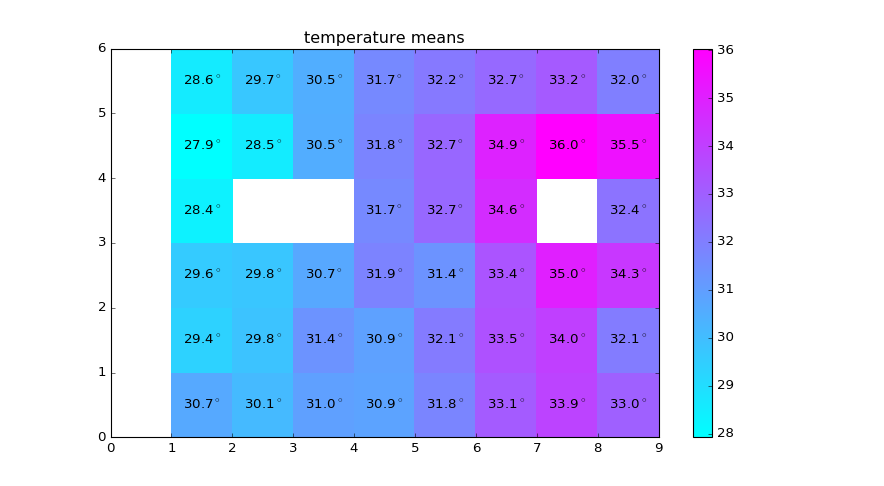

In [7]:
griddata = np.reshape(np.mean(mdata,axis=0), (6,9))
heatmap = plt.pcolor(griddata, cmap='cool')
plt.colorbar(heatmap)
for y in range(griddata.shape[0]):
    for x in range(griddata.shape[1]):
        val = griddata[y,x]          
        if val > 0.1:
            plt.text(x+0.5, y+0.5, '%.1f$^\circ$' % val, horizontalalignment='center', verticalalignment='center')
title=plt.title('temperature means')